In [63]:
import sys
import os
import scanpy as sc
import pandas as pd
import numpy as np
import loompy

print(sc.__version__)
print(loompy.__version__)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './objects/paga.h5ad'

loom_fn = "/Users/kriemo/Projects/sc_repos/vanotterloo/results/objects/ablast.loom"

obj_dir = "objects"
if not os.path.exists(obj_dir):
    os.makedirs(obj_dir)
 


1.4.4.post1
2.0.17
scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [64]:
sc.settings.figdir = "scanpy_figures"
sc.settings.autosave = True

In [65]:
# load
adata = sc.read_loom(loom_fn, sparse = True)

/miniconda3/envs/py37/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:
/miniconda3/envs/py37/lib/python3.6/site-packages/loompy/loom_layer.py:116: RuntimeWarning: invalid value encountered in greater
  nonzeros = np.where(vals > 0)


In [66]:
print(adata.obs)
print(adata.var)

                            ClusterID ClusterName  G2M_Score Phase  \
1_control_AAACCCAGTGTACGCC          1           0  -0.028306    G1   
1_control_AAACGAAAGGTGAGCT          1           0  -0.053618    G1   
1_control_AAACGAAAGTGCGACA          1           0  -0.000697    G1   
1_control_AAACGAAGTGAGATCG          1           0  -0.061459    G1   
1_control_AAACGCTCAGTGGCTC          1           0  -0.078850    G1   
...                               ...         ...        ...   ...   
2_mutant_TTCACGCAGGACACTG           7           6  -0.064462    G1   
2_mutant_TTCCGTGTCGAAATCC           7           6  -0.036630    G1   
2_mutant_TTCTGTATCCCTTGGT           7           6  -0.056208    G1   
2_mutant_TTGTGTTGTTCAAGGG           7           6  -0.043262    G1   
2_mutant_TTTGACTGTCGCACAC           7           6  -0.035784    G1   

                           RNA_snn_res_0_1 RNA_snn_res_0_2 RNA_snn_res_0_3  \
1_control_AAACCCAGTGTACGCC               0               0               0   
1_c

In [67]:
adata.var_names_make_unique()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
#sc.pp.scale(adata, max_value=10)
#sc.tl.pca(adata, svd_solver='arpack')


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


... storing 'ClusterName' as categorical
... storing 'Phase' as categorical
... storing 'RNA_snn_res_0_1' as categorical
... storing 'RNA_snn_res_0_2' as categorical
... storing 'RNA_snn_res_0_3' as categorical
... storing 'clusters' as categorical
... storing 'orig_ident' as categorical
... storing 'sample' as categorical
... storing 'tabula_muris_cell_type' as categorical


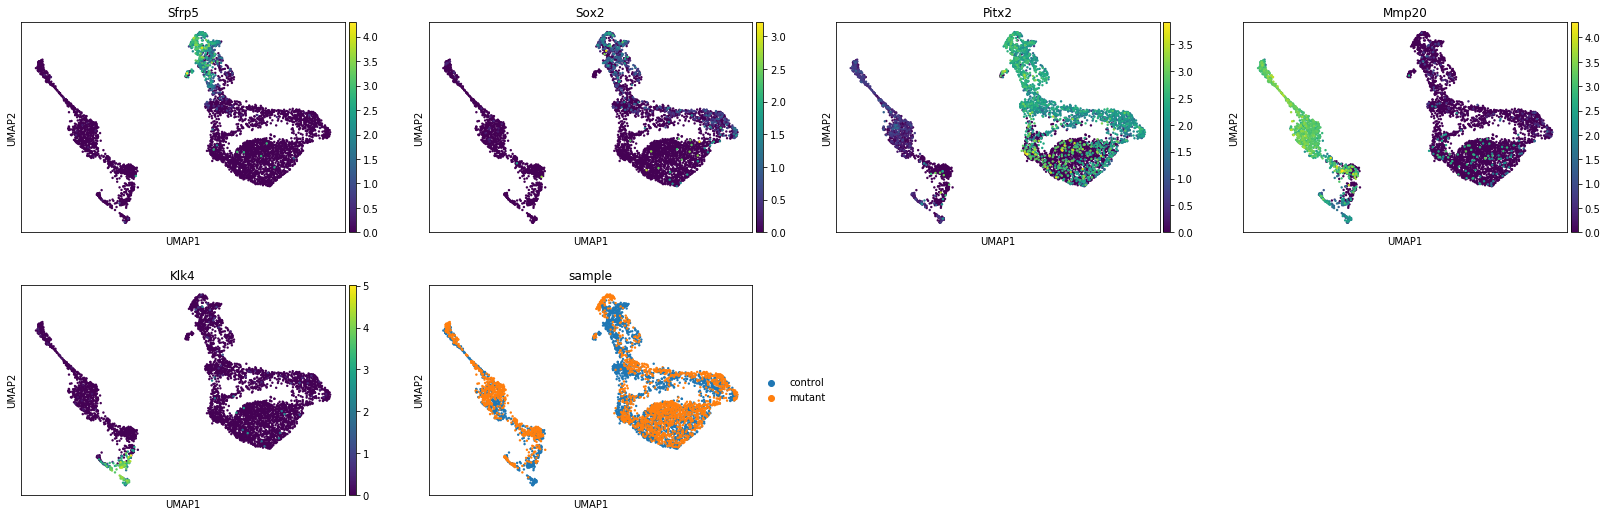

In [68]:
mdata = pd.read_csv("../../results/tables/ameloblast_metadata_2019_07_07.tsv.gz", sep="\t")
  
mdata = mdata[mdata.cell.isin(list(adata.obs.index.values))]


# reorder cell ids to match loom object
cids = pd.DataFrame({'cell' : adata.obs.index.values})
mdata = pd.merge(cids, mdata, how = 'left', on = 'cell')
mdata = mdata.dropna()


#add projections
umap_mat = np.column_stack((np.array(mdata["UMAP_1"]), np.array(mdata["UMAP_2"])))
adata.obsm['X_umap'] = umap_mat

sc.pl.umap(adata, color=['Sfrp5',  'Sox2', 'Pitx2',
                         'Mmp20', "Klk4", "sample"]) 
adata.write('./objects/full_dataset.h5ad')


In [174]:

adata = sc.read_h5ad('./objects/full_dataset.h5ad')

# see https://github.com/theislab/anndata/issues/185
adata.raw._varm = None
#idx = adata.obs['sample'].isin(['3', '6', '7', '8'])
#idx = adata.obs['sample'].isin(["control"])
#adata = adata[idx]
 
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')



computing PCA with n_comps = 50
    finished (0:00:14)


In [216]:
cluster_rename = {
  "0" : "Krt17_progenitors",
  "1" : "Sfrp5_TA",
  "2" : "Tnc_quiescent",
  "3" : "Mmp20_early_ameloblast",
  "4" : "Krt15_progenitors",
  "5" : "Notch_quiescent",
  "6" : "Krt27_early_ameloblast",
  "7" : "Mmp20_ameloblast_progenitor",
  "8" : "Klk4_late_ameloblast"
}

cluster_short_labels = {
  "0" : "0_Krt17_Prog",
  "1" : "1_Sfrp5_TA",
  "2" : "2_Tnc_Quies",
  "3" : "3_Mmp20_eAb",
  "4" : "4_Krt15_Prog",
  "5" : "5_Notch_Quies",
  "6" : "6_Krt27_eAb",
  "7" : "7_Mmp20_Ab_Prog",
  "8" : "8_Klk4_lAb"
}

ctypes = [cluster_rename[x] for x in list(adata.obs["clusters"].values)]
adata.obs["cell_types"] = pd.Categorical(ctypes, 
                                         categories=list(cluster_rename.values()),
                                         ordered=False)

ctypes = [cluster_short_labels[x] for x in list(adata.obs["clusters"].values)]
adata.obs["short_cell_types"] = pd.Categorical(ctypes, 
                                         categories=list(cluster_short_labels.values()),
                                         ordered=False)

col_palette = [
"#E69F00",
"#56B4E9",
"#009E73",
"#F0E442",
"#0072B2",
"#D55E00",
"#CC79A7",
"#999999",
"#A6CEE3",
"#1F78B4",
"#B2DF8A",
"#33A02C",
"#FB9A99"
]

adata.uns["cell_types_colors"] = np.array(col_palette[0:len(cluster_rename)])
adata.uns["clusters_colors"] = np.array(col_palette[0:len(cluster_rename)])
adata.uns["short_cell_types_colors"] = np.array(col_palette[0:len(cluster_rename)])

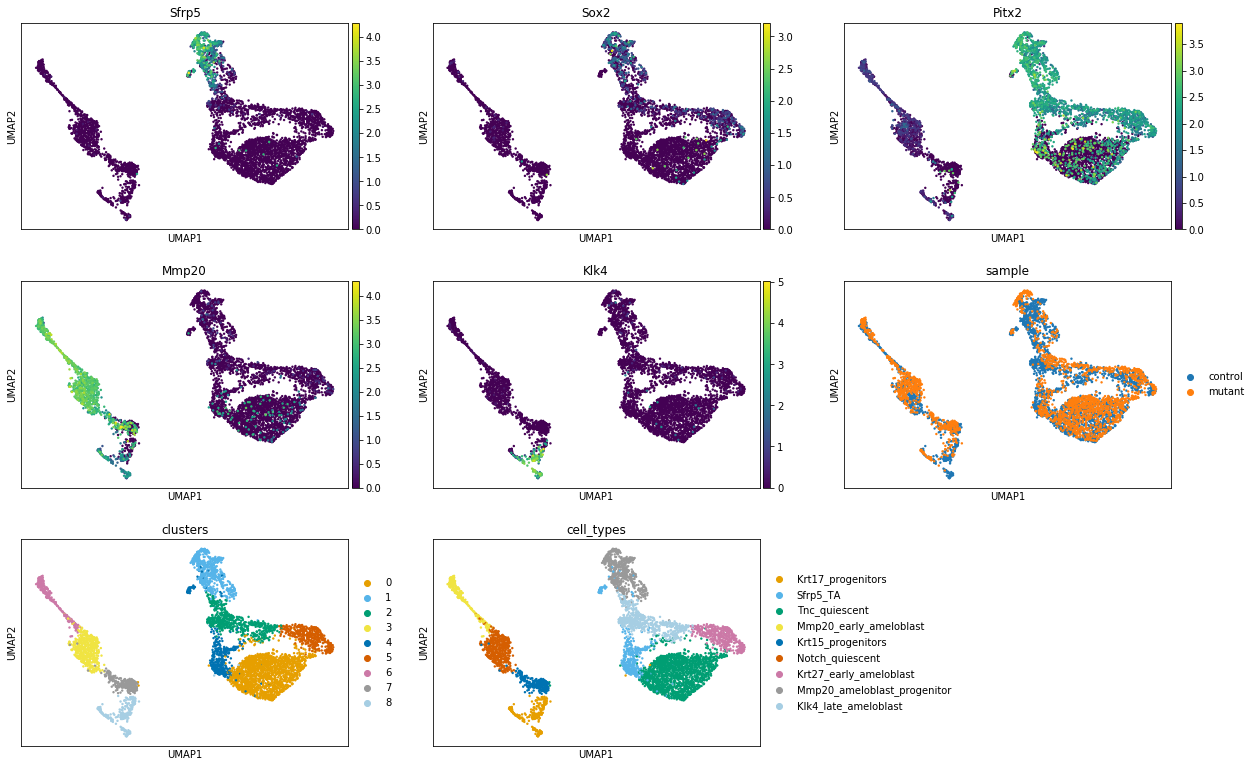

In [154]:
sc.pl.umap(adata, color=['Sfrp5',  'Sox2', 'Pitx2',
                         'Mmp20', "Klk4", "sample", "clusters", "cell_types"], 
           ncols = 3,
           save = "_various") 

In [185]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.draw_graph(adata)
sc.tl.paga(adata, groups='short_cell_types')

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:37)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


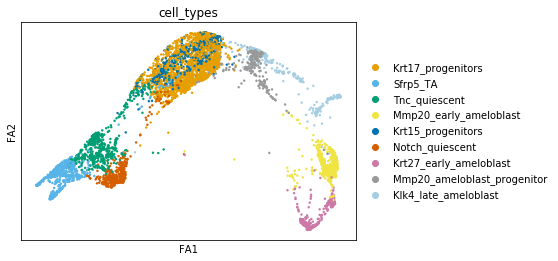

--> added 'pos', the PAGA positions (adata.uns['paga'])


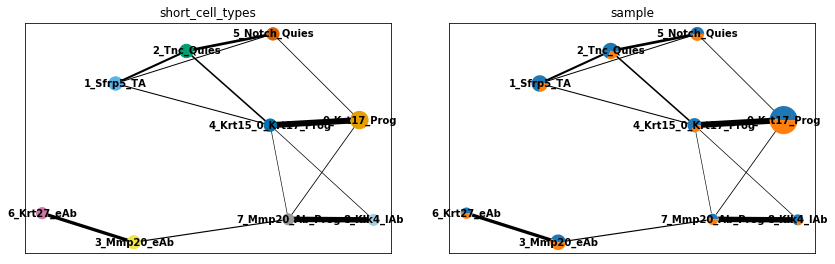

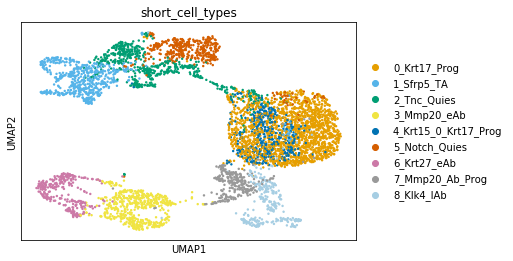

In [186]:
sc.pl.draw_graph(adata, color='cell_types')
sc.pl.paga(adata, color=['short_cell_types', 'sample'], threshold = 0.075)
sc.pl.umap(adata, color = ["short_cell_types"])

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:44)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


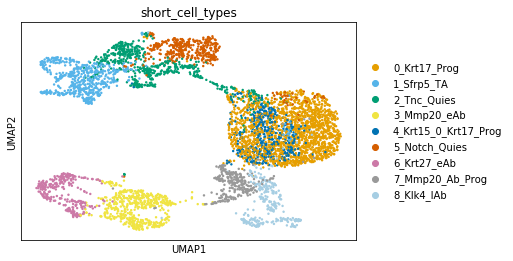

In [187]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.tl.umap(adata, init_pos=sc.tl._utils.get_init_pos_from_paga(adata))

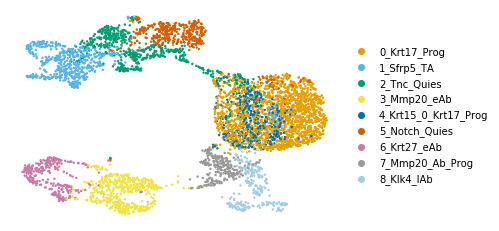

In [190]:
sc.pl.umap(adata, color = ["short_cell_types"], title = "", frameon = False, save = "_paga")

--> added 'pos', the PAGA positions (adata.uns['paga'])


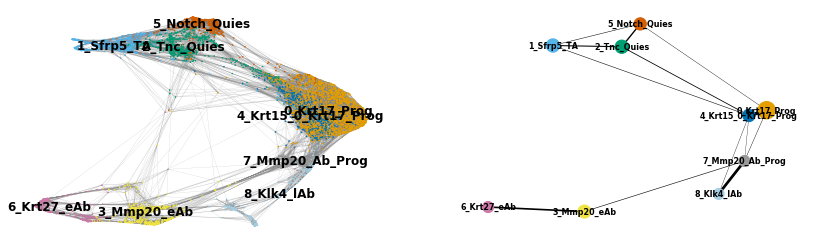

In [191]:
#sc.pl.draw_graph(adata, color='clusters', legend_loc='on data', edges=True)
sc.pl.paga_compare(
    adata, threshold=0.075, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=8, frameon=False, edges=True, save = "_paga_all")

In [193]:
root_condition = (adata.obs['clusters']  == '6') & (adata.obs['sample']  == 'control')
adata.uns['iroot'] = np.flatnonzero(root_condition)[0]
sc.tl.dpt(adata)
adata.obs["dpt_pseudotime_late_diff"] = adata.obs["dpt_pseudotime"]

root_condition = (adata.obs['clusters']  == '0') & (adata.obs['sample']  == 'control')
adata.uns['iroot'] = np.flatnonzero(root_condition)[0]
sc.tl.dpt(adata)

adata.obs["dpt_pseudotime_early_diff"] = adata.obs["dpt_pseudotime"]

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


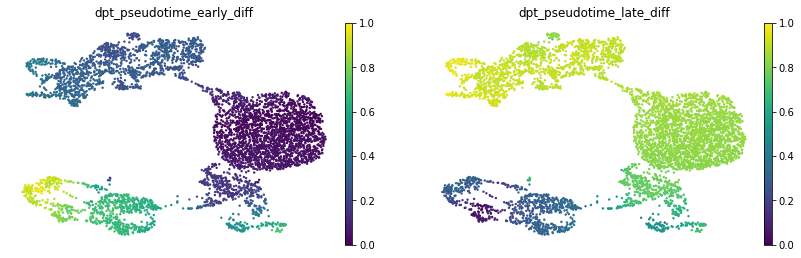

In [195]:
sc.pl.umap(adata, color=['dpt_pseudotime_early_diff', 'dpt_pseudotime_late_diff'], frameon = False, legend_loc='right margin', save = "_pseudotime")

IndexError: Key "Mmp20" is not valid observation/variable name/index.

In [263]:
gene_names = ['Grp', 'Pthlh', 'Sfrp5',   
              'Mmp20', 'Plod2', 'Ssr4'] 

paths = [('Early Differentiation', [0, 4, 5, 2, 1]),
         ('Late Differentiation', [6, 3, 7, 8])]


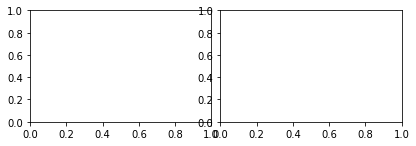

/miniconda3/envs/py37/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


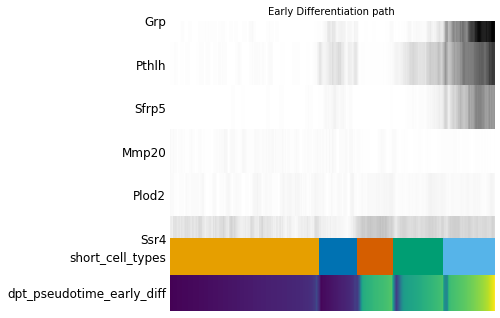

/miniconda3/envs/py37/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


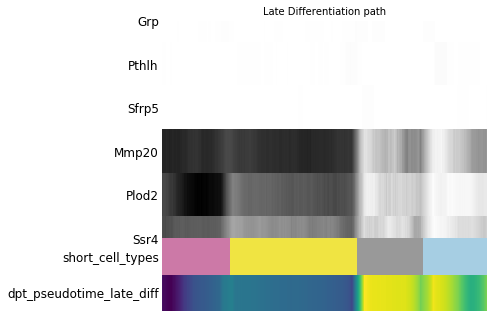

In [264]:

ipath = 0
sc.pl.paga_path(
        adata, paths[ipath][1], gene_names,
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['dpt_pseudotime_early_diff'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='short_cell_types',
        color_maps_annotations={'dpt_pseudotime_early_diff': 'viridis'},
        title='{} path'.format(paths[ipath][0]),
        return_data=False,
        show=True, save= "_early_pt")

ipath = 1
sc.pl.paga_path(
        adata, paths[ipath][1], gene_names,
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['dpt_pseudotime_late_diff'],
        show_yticks=True,
        show_colorbar=False,
        color_map='Greys',
        groups_key='short_cell_types',
        color_maps_annotations={'dpt_pseudotime_late_diff': 'viridis'},
        title='{} path'.format(paths[ipath][0]),
        return_data=False,
        show=True, save= "_late_pt")


/miniconda3/envs/py37/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


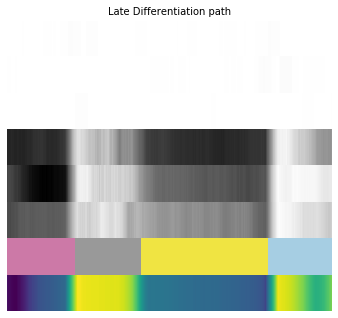

/miniconda3/envs/py37/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


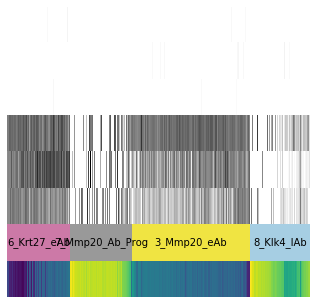

In [257]:
ipath = 1
sc.pl.paga_path(
        adata, paths[ipath][1], gene_names,
        show_node_names=False,
       # ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['dpt_pseudotime_late_diff'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='short_cell_types',
        color_maps_annotations={'dpt_pseudotime_late_diff': 'viridis'},
        title='{} path'.format(paths[ipath][0]),
        return_data=False,
        show=True, save= "_late_pt")



In [251]:
adata.obs

,ClusterID,ClusterName,G2M_Score,Phase,RNA_snn_res_0_1,RNA_snn_res_0_2,RNA_snn_res_0_3,S_Score,clusters,cor_value,...,orig_ident,percent_mt,sample,tabula_muris_cell_type,n_counts,cell_types,short_cell_types,dpt_pseudotime,dpt_pseudotime_late_diff,dpt_pseudotime_early_diff
index,,,,,,,,,,,,,,,,,,,,,
1_control_AAACCCAGTGTACGCC,1,0,-0.028306,G1,0,0,0,-0.039411,0,0.602602,...,control,8.532176,control,kidney collecting duct epithelial cell,1383.0,Krt17_progenitors,0_Krt17_Prog,0.000000,0.839517,0.000000
1_control_AAACGAAAGGTGAGCT,1,0,-0.053618,G1,0,0,0,-0.020294,0,0.602602,...,control,19.917440,control,kidney collecting duct epithelial cell,969.0,Krt17_progenitors,0_Krt17_Prog,0.036712,0.827034,0.036712
1_control_AAACGAAAGTGCGACA,1,0,-0.000697,G1,0,0,0,-0.023095,0,0.602602,...,control,16.836735,control,kidney collecting duct epithelial cell,980.0,Krt17_progenitors,0_Krt17_Prog,0.034058,0.841691,0.034058
1_control_AAACGAAGTGAGATCG,1,0,-0.061459,G1,0,0,0,-0.022145,0,0.602602,...,control,12.557528,control,kidney collecting duct epithelial cell,1521.0,Krt17_progenitors,0_Krt17_Prog,0.027693,0.843340,0.027693
1_control_AAACGCTCAGTGGCTC,1,0,-0.078850,G1,0,0,0,-0.037921,0,0.602602,...,control,8.592425,control,kidney collecting duct epithelial cell,1769.0,Krt17_progenitors,0_Krt17_Prog,0.028793,0.846583,0.028793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_mutant_TTCACGCAGGACACTG,7,6,-0.064462,G1,2,6,6,-0.038182,6,0.562413,...,mutant,2.812781,mutant,bladder urothelial cell,34521.0,Krt27_early_ameloblast,6_Krt27_eAb,0.877889,0.270249,0.877889
2_mutant_TTCCGTGTCGAAATCC,7,6,-0.036630,G1,2,6,6,-0.028204,6,0.562413,...,mutant,3.575912,mutant,bladder urothelial cell,27881.0,Krt27_early_ameloblast,6_Krt27_eAb,0.899211,0.282923,0.899211
2_mutant_TTCTGTATCCCTTGGT,7,6,-0.056208,G1,2,6,6,-0.022042,6,0.562413,...,mutant,2.767730,mutant,bladder urothelial cell,35661.0,Krt27_early_ameloblast,6_Krt27_eAb,0.869403,0.273645,0.869403


In [102]:
out_df = sc.get.obs_df(adata, 
              keys = adata.obs.keys(), 
              obsm_keys = [("X_umap", 0), ("X_umap", 1),
                           ("X_draw_graph_fa", 0), ("X_draw_graph_fa", 1)])

out_df.to_csv("paga_results.csv")

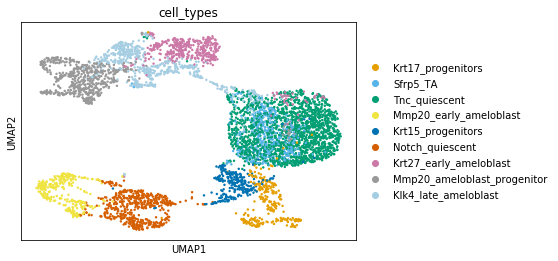

In [147]:
sc.pl.umap(adata, color = "cell_types")

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22']

['Krt17_progenitors',
 'Sfrp5_TA',
 'Tnc_quiescent',
 'Mmp20_early_ameloblast',
 'Krt15_progenitors',
 'Notch_quiescent',
 'Krt27_early_ameloblast',
 'Mmp20_ameloblast_progenitor',
 'Klk4_late_ameloblast']

,ClusterID,ClusterName,G2M_Score,Phase,RNA_snn_res_0_1,RNA_snn_res_0_2,RNA_snn_res_0_3,S_Score,clusters,cor_value,nCount_RNA,nFeature_RNA,orig_ident,percent_mt,sample,tabula_muris_cell_type,n_counts,cell_types
index,,,,,,,,,,,,,,,,,,
1_control_AAACCCAGTGTACGCC,1,0,-0.028306,G1,0,0,0,-0.039411,0,0.602602,1383.0,766,control,8.532176,control,kidney collecting duct epithelial cell,1383.0,Tnc_quiescent
1_control_AAACGAAAGGTGAGCT,1,0,-0.053618,G1,0,0,0,-0.020294,0,0.602602,969.0,466,control,19.917440,control,kidney collecting duct epithelial cell,969.0,Tnc_quiescent
1_control_AAACGAAAGTGCGACA,1,0,-0.000697,G1,0,0,0,-0.023095,0,0.602602,980.0,499,control,16.836735,control,kidney collecting duct epithelial cell,980.0,Tnc_quiescent
1_control_AAACGAAGTGAGATCG,1,0,-0.061459,G1,0,0,0,-0.022145,0,0.602602,1521.0,759,control,12.557528,control,kidney collecting duct epithelial cell,1521.0,Tnc_quiescent
1_control_AAACGCTCAGTGGCTC,1,0,-0.078850,G1,0,0,0,-0.037921,0,0.602602,1769.0,866,control,8.592425,control,kidney collecting duct epithelial cell,1769.0,Tnc_quiescent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_mutant_TTCACGCAGGACACTG,7,6,-0.064462,G1,2,6,6,-0.038182,6,0.562413,34521.0,4784,mutant,2.812781,mutant,bladder urothelial cell,34521.0,Mmp20_early_ameloblast
2_mutant_TTCCGTGTCGAAATCC,7,6,-0.036630,G1,2,6,6,-0.028204,6,0.562413,27881.0,4342,mutant,3.575912,mutant,bladder urothelial cell,27881.0,Mmp20_early_ameloblast
2_mutant_TTCTGTATCCCTTGGT,7,6,-0.056208,G1,2,6,6,-0.022042,6,0.562413,35661.0,4904,mutant,2.767730,mutant,bladder urothelial cell,35661.0,Mmp20_early_ameloblast


,ClusterID,ClusterName,G2M_Score,Phase,RNA_snn_res_0_1,RNA_snn_res_0_2,RNA_snn_res_0_3,S_Score,clusters,cor_value,nCount_RNA,nFeature_RNA,orig_ident,percent_mt,sample,tabula_muris_cell_type,n_counts,cell_types
index,,,,,,,,,,,,,,,,,,
1_control_AAACCCAGTGTACGCC,1,0,-0.028306,G1,0,0,0,-0.039411,0,0.602602,1383.0,766,control,8.532176,control,kidney collecting duct epithelial cell,1383.0,Tnc_quiescent
1_control_AAACGAAAGGTGAGCT,1,0,-0.053618,G1,0,0,0,-0.020294,0,0.602602,969.0,466,control,19.917440,control,kidney collecting duct epithelial cell,969.0,Tnc_quiescent
1_control_AAACGAAAGTGCGACA,1,0,-0.000697,G1,0,0,0,-0.023095,0,0.602602,980.0,499,control,16.836735,control,kidney collecting duct epithelial cell,980.0,Tnc_quiescent
1_control_AAACGAAGTGAGATCG,1,0,-0.061459,G1,0,0,0,-0.022145,0,0.602602,1521.0,759,control,12.557528,control,kidney collecting duct epithelial cell,1521.0,Tnc_quiescent
1_control_AAACGCTCAGTGGCTC,1,0,-0.078850,G1,0,0,0,-0.037921,0,0.602602,1769.0,866,control,8.592425,control,kidney collecting duct epithelial cell,1769.0,Tnc_quiescent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_mutant_TTCACGCAGGACACTG,7,6,-0.064462,G1,2,6,6,-0.038182,6,0.562413,34521.0,4784,mutant,2.812781,mutant,bladder urothelial cell,34521.0,Mmp20_early_ameloblast
2_mutant_TTCCGTGTCGAAATCC,7,6,-0.036630,G1,2,6,6,-0.028204,6,0.562413,27881.0,4342,mutant,3.575912,mutant,bladder urothelial cell,27881.0,Mmp20_early_ameloblast
2_mutant_TTCTGTATCCCTTGGT,7,6,-0.056208,G1,2,6,6,-0.022042,6,0.562413,35661.0,4904,mutant,2.767730,mutant,bladder urothelial cell,35661.0,Mmp20_early_ameloblast
